# PLN Assignment 1

In the scope of the DARGMINTS project, an annotation project was carried out which consisted of annotating argumentation structures in opinion articles published in the Público newspaper. The annotation included several layers:

Selecting text spans that are taken to have an argumentative role (either as premises or conclusions of arguments) -- these are Argumentative Discourse Units (ADU).
Connecting such ADUs through support or attack relations.
Classifying the propositional content of ADUs as propositions of fact, propositions of value, or propositions of policy; within propositions of value, distinguish between those with a positive (+) or negative (-) connotation.
In a proposition of fact, the content corresponds to a piece of information that can be checked for truthness. This does not usually happen with propositions of value, which denote value judgments with a strong subjective nature; often, they also have a (positive or negative) polarity attached. A proposition of policy prescribes or suggests a certain line of action, often mentioning the agents or entities that are capable of carrying out such policies.

The aim of this assignment is to build a classifier of types of ADUs, thus focusing on the last annotation step described above. For that, you have access to two different files:

A file containing the content of each annotated ADU span and its 5-class classification: Value, Value(+), Value(-), Fact, or Policy. For each ADU, we also know the annotator and the document from which it has been taken.
A file containing details for each opinion article that has been annotated, including the full article content.
Besides ADU contents, you can make use of any contextual information provided in the corresponding opinion article.

Each opinion article has been annotated by 3 different annotators. For that reason, you will find in the ADU file an indication of which annotator has obtained the ADU. It may happen that the same ADU has been annotated by more than one annotator. When that is the case, they do not necessarily agree on the type of proposition.

How good a classifier (or set of classifiers) can you get? Don't forget to properly split the dataset in a sensible manner, so that you have a proper test set. Start by obtaining an arbitrary baseline, against which you can then compare your improvements.

## Importing the data

In order to fulfill this NLP task we will use `pandas`, `sklearn`, `nltk`, `numpy`, `matplotlib`, `seaborn` and other Python libraries


In [11]:
!git clone https://github.com/Caio-Nogueira/FEUP-PLN.git

assignment1.ipynb  data/  README.md  statistics/


In [12]:
import pandas as pd

ADUs = pd.read_excel("data/OpArticles_ADUs.xlsx")
articles = pd.read_excel("data/OpArticles.xlsx")

ADUs.isnull().values.any() #check NaNs


False

In [ ]:
ADUs["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64

## Handling repeated text spans

Some text spans were annotated by more than one annotator. Therefore, it may be the case that some text spans have different labels, which may harm the training phase.

In [13]:
import numpy as np

unique_spans = np.unique(ADUs[['article_id', 'ranges']].values)
(unique_spans.shape, ADUs["tokens"].shape)

((12302,), (16743,))

As we can see, more than 4000 text spans were evaluated by more than one annotator. Now let's check how many of these text spans receive different labels

## Data preparation

The next step is to cleanup the dataset, applying text normalization techniques:
 - Removing non-alphabetic chars
 - Lowercasing
 - Removing stop words
 - Stemming/lemmatization
 
However, before applying these techniques, let's try to remove the repeated annotations that may confuse the classifiers on the future steps. In order to decide which is the correct label for each (article_id, range) pair, we compute the majority.

In [14]:
grouped_df = ADUs.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": []}

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    final_label = max(dict_counts.items(), key=lambda x: x[1])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(final_label[0])
    
dataset = pd.DataFrame(dataset_dict, columns = ["tokens", "label"])
dataset


,tokens,label
0,presumo que essas partilhas tenham gerado um e...,Value
1,essas partilhas tenham gerado um efeito bola d...,Value
2,o post não tardou a chegar ao conhecimento da ...,Value
3,esta questão ter [justificadamente] despertado...,Value
4,a ocasião propicia um debate amplo na sociedad...,Value
...,...,...
12016,eticamente é reprovável,Value(-)
12017,"eticamente é reprovável e, o bom senso, aconse...",Value
12018,"o bom senso, aconselha a não o fazer",Value
12019,Um presidente de câmara pode ter a sua preferê...,Value


In [ ]:
print(ADUs["label"].value_counts())
dataset["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64


Value       5748
Fact        3001
Value(-)    1872
Value(+)     889
Policy       511
Name: label, dtype: int64

We managed to reduce the amount of rows in the dataframe -> some of them had repeated/conflictuous labels. 

## Analyzing Stopwords
Some stopwords from `nltk` should not be ignored by the model, as they have correlation with the label.

In [17]:
from nltk.corpus import stopwords
import nltk

stopwords_list = stopwords.words("portuguese")


stopwords_list.remove("não")
stopwords_list.remove("muito")
stopwords_list.remove("mais")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!python -m spacy download pt_core_news_sm

In [25]:
import spacy
from spacy.lang.pt.examples import sentences 
import pt_core_news_sm

nlp = pt_core_news_sm.load()
test_sentence = "Os combustíveis atingiram picos históricos na passada sexta-feira."
for token in nlp(test_sentence):
    print(token.text, token.pos_, token.dep_)

Os DET det
combustíveis SYM nsubj
atingiram VERB ROOT
picos NOUN obj
históricos ADJ amod
na PROPN obj
passada VERB acl
sexta-feira NOUN obl
. PUNCT punct


In [27]:
import re
#nltk.download('rslp')
from nltk.stem import RSLPStemmer # portuguese stemmer
corpus = []
stemmer = RSLPStemmer()
for i in range(0, dataset['tokens'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z!?]', ' ', dataset['tokens'][i])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([stemmer.stem(w) for w in review.split() if not w in stopwords_list])
    corpus.append(review)

#print(corpus)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


## POS-tagging

In [55]:
#Add a new column with POS-tags that will be gathered next
POS_list = []
#ADUs["POS"] = []

for row in ADUs.iterrows():
  POS_list.append((row[1]["article_id"] + row[1]["ranges"]))

ADUs["POS"] = POS_list

In [56]:
import nltk


for i, group in grouped_df:
  article = articles.loc[articles["article_id"] == i[0]]
  
  range = group["ranges"].unique()[0]
  start = eval(range)[0][0]
  end = eval(range)[0][1] 
  body = article["body"].values[0]
  
  body_sentences = nltk.tokenize.sent_tokenize(body)
  current_pos, current_sent = 0,0
  while current_pos < start:
    if current_sent == len(body_sentences): break
    current_pos += len(body_sentences[current_sent])
    current_sent += 1
  #print(body_sentences[current_sent - 1])
  tags = [token.pos_ for token in nlp(body_sentences[current_sent - 1])]
  test = ADUs.loc[ADUs["POS"] == i[0] + i[1]]

  ADUs["POS"].replace(i[0] + i[1], " ".join(tags), inplace=True)

  

In [57]:
ADUs["POS"].describe()

count                                    16743
unique                                    5836
top       DET NOUN VERB ADP DET ADJ NOUN PROPN
freq                                        57
Name: POS, dtype: object

## Saving pre-processed data

In [59]:
ADUs.to_excel("data/ADUs_pre-processed.xlsx")


## Generating a data set

We need to transform the corpus into a collection that can be handled by a machine learning model. We will be using `sklearn`'s TfidfVectorizer class

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#set max_features = 10000 to select k features with the highest corpus frequency
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = 3)
X = vectorizer.fit_transform(corpus).toarray()

print(X.shape)


In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
y = dataset["label"]
print(y.shape)
print(y.head())

(12021,)
0    Value
1    Value
2    Value
3    Value
4    Value
Name: label, dtype: object


## Splitting the dataset into training and testing

The next step is to split the dataset into training and testing. We will be using a 80%-20% split. Since classes are unbalanced (*Value* examples are significantly more abundant than *Policy* examples), we need to stratify both sets -> try to get a similar class distribution for each set.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(9616, 8859) (9616,)
(2405, 8859) (2405,)

Label distribution in the training set:
Value       4580
Fact        2456
Value(-)    1465
Value(+)     707
Policy       408
Name: label, dtype: int64

Label distribution in the test set:
Value       1168
Fact         545
Value(-)     407
Value(+)     182
Policy       103
Name: label, dtype: int64


## Training the models


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

cross_validation = StratifiedKFold(n_splits=5)

### Naive Bayes
To start off, we will train a single (`Naive Bayes`) classifier that evaluates the likelihood of a document being of one of the 5 classes. This will set the baseline for which the improvements will be measured.


In [ ]:

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy score:  0.49812889812889816


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


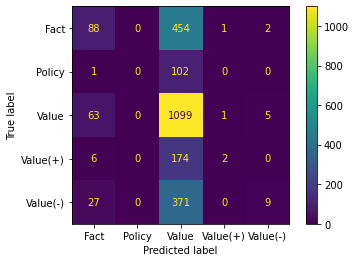

,Precision,Recall,F1
Fact,0.475676,0.161468,0.241096
Policy,0.000000,0.000000,0.000000
Value,0.499545,0.940925,0.652613
Value(+),0.500000,0.010989,0.021505
Value(-),0.562500,0.022113,0.042553


In [ ]:

def print_metrics(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    print("Accuracy score: ", accuracy_score(y_test, y_pred))
    metrics_df = pd.DataFrame({"Precision": precision_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "Recall": recall_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "F1": f1_score(y_test, y_pred, labels = classes, average = None).tolist()},
                             index = classes)
    
    plt.show()
    return metrics_df.head()
    
print_metrics(y_test, y_pred, clf.classes_)

Since some classifiers like SVM and Logistic Regression cannot handle multi-class classification, let's use the One vs Rest classifier. This way, we can transform this problem into a binary classification problem -> one classifier for each class.

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy score:  0.4856548856548857


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


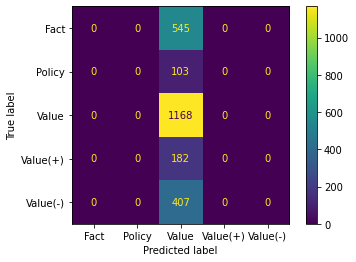

,Precision,Recall,F1
Fact,0.000000,0.0,0.000000
Policy,0.000000,0.0,0.000000
Value,0.485655,1.0,0.653792
Value(+),0.000000,0.0,0.000000
Value(-),0.000000,0.0,0.000000


In [ ]:


model_to_set = RandomForestClassifier(n_jobs=-1)

cross_validation = StratifiedKFold(n_splits=5)
parameters = {
    "max_depth": [int(x) for x in np.linspace(10, 110, num=5)],
    "min_samples_leaf": [int(x) for x in np.linspace(50, 2000, num=5)],
    "criterion": ["gini", "entropy"]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring="accuracy", cv=cross_validation, n_jobs=-1, verbose=1)

model_tunning.fit(X_train, y_train)
model_tunning.best_score_
print_metrics(y_test, model_tunning.predict(X_test), clf.classes_)


## Scaling the data

Some linear models (like SVM or SGD classifiers) use euclidean distances and benefit from the normalization of the data.

In [ ]:


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## SGD Classifier

Let's now apply the Stochastic Gradient Descent optimization with a linear SVM model (`loss='hinge'`) and a Logistic Regression model (`loss=log`). Moreover, we can tune some hyperparameters to get the best possible model.
SGD implementation from sklearn optimizes the loss function to converge faster, as they use stochastic gradient descent instead of gradient descent.

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'loss': 'modified_huber'}
Accuracy score:  0.47442827442827445


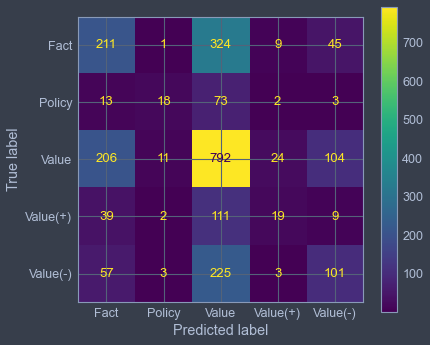

,Precision,Recall,F1
Fact,0.401141,0.357627,0.378136
Policy,0.514286,0.165138,0.250000
Value,0.519344,0.696570,0.595041
Value(+),0.333333,0.105556,0.160338
Value(-),0.385496,0.259640,0.310292


In [ ]:



"""
l1-regularization -> 'built-in' feature selection (fewer features)
l2-regularization -> Prefers weight vectors with many small weights
"""

max_iterations = 10**6/np.ceil(X_train.shape[0] / 10) #Empirically,the model converges after 10^6/n where n 
                                        # the size of the test set

sgd_model = SGDClassifier(penalty="l2", 
                          max_iter=np.ceil(max_iterations/10), average=True)
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={
    "alpha": 10.0**-np.arange(1,5),
    "loss": ['log', 'modified_huber']
}, cv=cross_validation, scoring="f1_weighted", verbose = 1)

sgd_gs.fit(X_train, y_train)
#sgd_gs.best_score_
print(sgd_gs.best_params_)
print_metrics(y_test, sgd_gs.predict(X_test), sgd_gs.classes_)

In [ ]:
# Linear SVM model -> loss = 'hinge'

sgd_classifier = SGDClassifier(n_jobs=-1, penalty="l2", verbose = 1, shuffle=True, 
                               loss="hinge", max_iter=max_iterations)

sgd_classifier.fit(X_train, y_train)
print_metrics(y_test, sgd_classifier.predict(X_test), sgd_classifier.classes_)

## Linear SVM Classifier
To establish a comparison in terms of performance, we will use the Linear SVM classifier.


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1068
max_resources_: 9616
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 1068
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 3204
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 9612
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LibLinear]Accuracy score:  0.5068607068607068


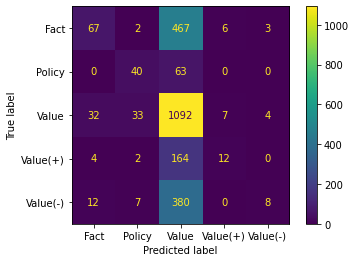

,Precision,Recall,F1
Fact,0.582609,0.122936,0.203030
Policy,0.476190,0.388350,0.427807
Value,0.504155,0.934932,0.655069
Value(+),0.480000,0.065934,0.115942
Value(-),0.533333,0.019656,0.037915


In [ ]:



svm_model = LinearSVC(class_weight="balanced", verbose=1)

svm_gs = HalvingGridSearchCV(svm_model, n_jobs=-1, param_grid = {
    "C": np.logspace(-4,4,5),
    "loss": ["hinge", "squared_hinge"]
}, cv=5, scoring="accuracy", verbose=3)

svm_gs.fit(X_train, y_train)
print_metrics(y_test, svm_gs.predict(X_test), svm_gs.classes_)

## Logistic Regression Classifier
We can now do the same apply the Logistic Regression classifier and compare it with the previously obtained models with SGD optimization.


In [ ]:

# Logistic Regression model
lr_model = LogisticRegression(n_jobs=-1, verbose=1)

lr_gs = GridSearchCV(lr_model, n_jobs=-1, param_grid={
    "max_iter": [100, 200, 500, 1000],
    "solver": ["sag", 'saga', 'lbfgs', "newton-cg"],
    "C": np.logspace(-4, 4, 20)
}, cv=cross_validation, scoring="accuracy", verbose = True)

lr_gs.fit(X_train, y_train)
print_metrics(y_test, lr_gs.predict(X_test), lr_gs.classes_)